In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from utils import (
    generate_class_vectors,
    generate_class_vectors_hemispheres,
    SigLIPLoss,
    SigLIPExperiment,
)
from utils.siglip_experiment import *
%load_ext autoreload
%autoreload 2

# Experiments with Multiple Modalities

In [4]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_modalities = 4  # Number of modalities to align
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

initial_temperature = 10.0
initial_relative_bias = 0.0
bias_is_trainable = True

#print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_modalities={n_modalities}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

# Initialize vectors for each modality
modality_vectors = []
for _ in range(n_modalities):
    U_init, _ = generate_class_vectors(n_classes, dim, device_str)
    modality_vectors.append(nn.Parameter(U_init / torch.norm(U_init, dim=1, keepdim=True)))

# Initialize loss function
criterion = SigLIPLoss(
    temperature=initial_temperature,
    relative_bias=initial_relative_bias,
    trainable_bias=bias_is_trainable
).to(device_str)

# Setup optimizer
params = [{'params': vectors, 'lr': 1e-2} for vectors in modality_vectors]
params.append({'params': criterion.parameters(), 'lr': 1e-2})
optimizer = torch.optim.Adam(params)

# Training loop
relative_bias_losses = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Calculate pairwise losses between all modalities
    total_loss = 0
    for i in range(n_modalities):
        for j in range(i+1, n_modalities):
            loss = criterion(modality_vectors[i], modality_vectors[j])
            total_loss += loss
    
    total_loss = total_loss / (n_modalities * (n_modalities - 1) / 2)  # Average over pairs
    total_loss.backward()
    optimizer.step()
    
    # Re-project vectors back onto unit sphere
    with torch.no_grad():
        for vectors in modality_vectors:
            vectors.data = vectors.data / vectors.data.norm(dim=1, keepdim=True)
    
    relative_bias_losses.append(total_loss.item())

print("\n--- Training Complete ---")
print(f"Final Loss: {relative_bias_losses[-1]:.4f}")
print(f"Final Temperature: {criterion.get_temperature():.4f}")
print(f"Final Bias Value: {criterion.get_bias():.4f}")

# Store final vectors
final_vectors = [vectors.detach() for vectors in modality_vectors]

Running experiment with: n_classes=100, dim=10, n_modalities=4, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0.0, trainable_bias=True

--- Training Complete ---
Final Loss: 0.0000
Final Temperature: 56.2748
Final Bias Value: 0.7210


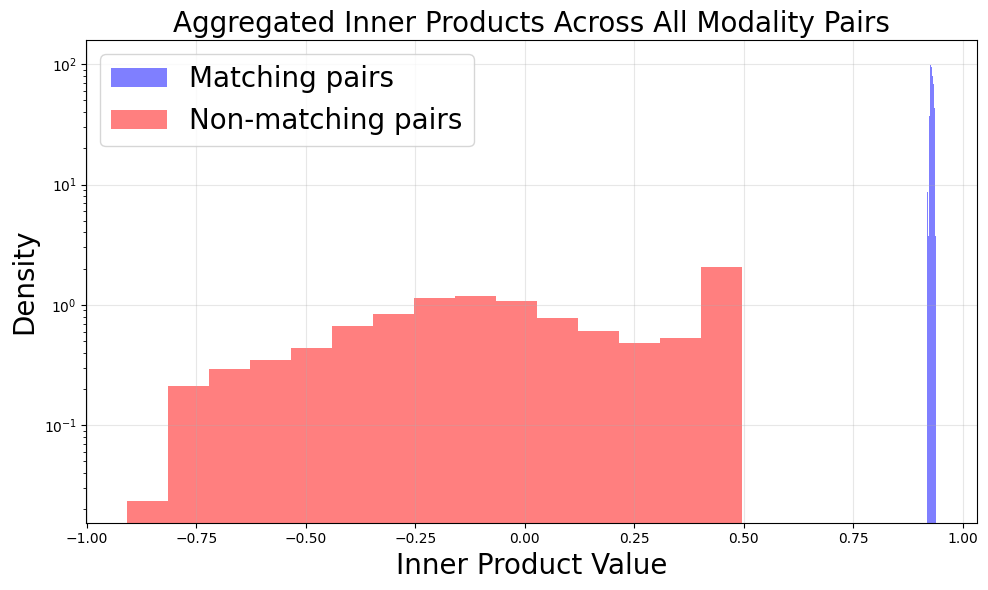

In [5]:
# Aggregate matching/non-matching inner products across all modality pairs into one plot
combined_matching = []
combined_nonmatching = []

for i in range(n_modalities):
        for j in range(i + 1, n_modalities):
                ip = final_vectors[i] @ final_vectors[j].T

                # Matching pairs (diagonal)
                combined_matching.extend(torch.diag(ip).detach().cpu().numpy())

                # Non-matching pairs (off-diagonal)
                mask = ~torch.eye(n_classes, dtype=bool, device=ip.device)
                combined_nonmatching.extend(ip[mask].detach().cpu().numpy())

plt.figure(figsize=(10, 6))
plt.hist(combined_matching, bins=15, alpha=0.5, label='Matching pairs', color='blue', density=True, log=True)
plt.hist(combined_nonmatching, bins=15, alpha=0.5, label='Non-matching pairs', color='red', density=True, log=True)

plt.xlabel('Inner Product Value', fontsize = 20)
plt.ylabel('Density', fontsize = 20)
plt.title('Aggregated Inner Products Across All Modality Pairs', fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_modalities = 4  # Number of modalities to align
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

initial_temperature = 10.0
initial_bias = -10.0
bias_is_trainable = True

print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_modalities={n_modalities}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

# Initialize vectors for each modality
modality_vectors = []
for _ in range(n_modalities):
    U_init, _ = generate_class_vectors(n_classes, dim, device_str)
    modality_vectors.append(nn.Parameter(U_init / torch.norm(U_init, dim=1, keepdim=True)))

# Initialize loss function
criterion = SigLIPLoss(
    temperature=initial_temperature,
    bias=initial_bias,
    trainable_bias=bias_is_trainable,
    relative_bias_parameterization=False
).to(device_str)

# Setup optimizer
params = [{'params': vectors, 'lr': 1e-2} for vectors in modality_vectors]
params.append({'params': criterion.parameters(), 'lr': 1e-2})
optimizer = torch.optim.Adam(params)

# Training loop
bias_losses = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Calculate pairwise losses between all modalities
    total_loss = 0
    for i in range(n_modalities):
        for j in range(i+1, n_modalities):
            loss = criterion(modality_vectors[i], modality_vectors[j])
            total_loss += loss
    
    total_loss = total_loss / (n_modalities * (n_modalities - 1) / 2)  # Average over pairs
    total_loss.backward()
    optimizer.step()
    
    # Re-project vectors back onto unit sphere
    with torch.no_grad():
        for vectors in modality_vectors:
            vectors.data = vectors.data / vectors.data.norm(dim=1, keepdim=True)
    
    bias_losses.append(total_loss.item())

print("\n--- Training Complete ---")
print(f"Final Loss: {bias_losses[-1]:.4f}")
print(f"Final Temperature: {criterion.get_temperature():.4f}")
print(f"Final Bias Value: {criterion.get_bias():.4f}")

# Store final vectors
final_vectors = [vectors.detach() for vectors in modality_vectors]

Using device: cpu
Running experiment with: n_classes=100, dim=10, n_modalities=4, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0.0, trainable_bias=True

--- Training Complete ---
Final Loss: 0.0000
Final Temperature: 165.6806
Final Bias Value: -8.8291


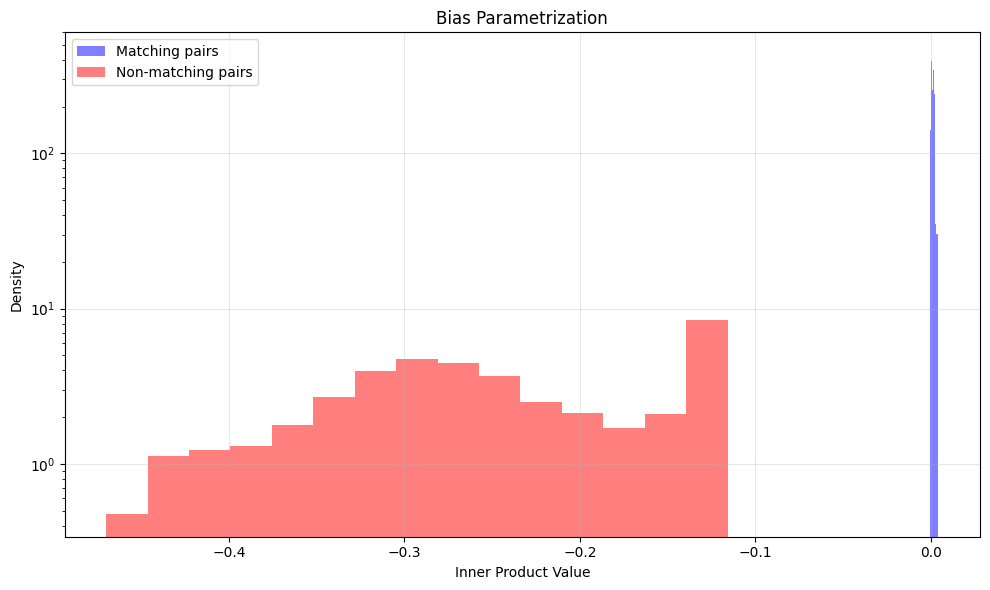

In [7]:
# Calculate all pairwise inner products between modalities
plt.figure(figsize=(10, 6))

# Collect all matching and non-matching pairs
all_matching_pairs = []
all_non_matching_pairs = []

for i in range(n_modalities):
    for j in range(i+1, n_modalities):
        inner_products = torch.matmul(final_vectors[i], final_vectors[j].t())
        
        # Get matching pairs (diagonal elements)
        matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
        all_matching_pairs.extend(matching_pairs)
        
        # Get non-matching pairs (off-diagonal elements)
        mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
        non_matching_pairs = inner_products[mask].detach().cpu().numpy()
        all_non_matching_pairs.extend(non_matching_pairs)

# Plot single histograms for all matching and non-matching pairs
plt.hist(all_matching_pairs, bins=15, alpha=0.5, 
        label='Matching pairs', color='blue', density=True, log=True)
plt.hist(all_non_matching_pairs, bins=15, alpha=0.5, 
        label='Non-matching pairs', color='red', density=True, log=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(all_matching_pairs)
max_non_matching = np.max(all_non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
# plt.axvline(x=midpoint, color='black', linestyle='--', label='Separation Point')

plt.xlabel('Inner Product Value')
plt.ylabel('Density')
plt.title('Bias Parametrization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_modalities = 4  # Number of modalities to align
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

initial_temperature = 200.0
initial_bias = -10.0
bias_is_trainable = False

print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_modalities={n_modalities}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

# Initialize vectors for each modality
modality_vectors = []
for _ in range(n_modalities):
    U_init, _ = generate_class_vectors(n_classes, dim, device_str)
    modality_vectors.append(nn.Parameter(U_init / torch.norm(U_init, dim=1, keepdim=True)))

# Initialize loss function
criterion = SigLIPLoss(
    temperature=initial_temperature,
    trainable_temp=False,
    bias=initial_bias,
    trainable_bias=bias_is_trainable,
    relative_bias_parameterization=True
).to(device_str)

# Setup optimizer
params = [{'params': vectors, 'lr': 1e-2} for vectors in modality_vectors]
params.append({'params': criterion.parameters(), 'lr': 1e-2})
optimizer = torch.optim.Adam(params)

# Training loop
fixed_losses = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Calculate pairwise losses between all modalities
    total_loss = 0
    for i in range(n_modalities):
        for j in range(i+1, n_modalities):
            loss = criterion(modality_vectors[i], modality_vectors[j])
            total_loss += loss
    
    total_loss = total_loss / (n_modalities * (n_modalities - 1) / 2)  # Average over pairs
    total_loss.backward()
    optimizer.step()
    
    # Re-project vectors back onto unit sphere
    with torch.no_grad():
        for vectors in modality_vectors:
            vectors.data = vectors.data / vectors.data.norm(dim=1, keepdim=True)
    
    fixed_losses.append(total_loss.item())

print("\n--- Training Complete ---")
print(f"Final Loss: {fixed_losses[-1]:.4f}")
print(f"Final Temperature: {criterion.get_temperature():.4f}")
print(f"Final Bias Value: {criterion.get_bias():.4f}")

# Store final vectors
final_vectors = [vectors.detach() for vectors in modality_vectors]

Using device: cpu
Running experiment with: n_classes=100, dim=10, n_modalities=4, n_epochs=10000
Loss params: temperature=200.0, relative_bias=0.0, trainable_bias=False

--- Training Complete ---
Final Loss: 0.0752
Final Temperature: 200.0000
Final Bias Value: 0.0000


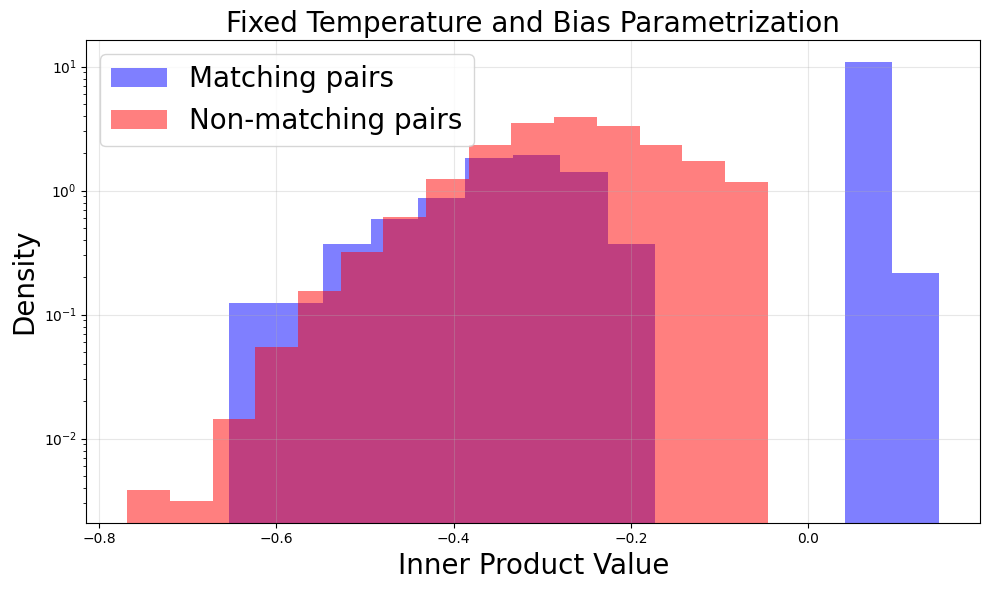

In [9]:
# Calculate all pairwise inner products between modalities
plt.figure(figsize=(10, 6))

# Collect all matching and non-matching pairs
all_matching_pairs = []
all_non_matching_pairs = []

for i in range(n_modalities):
    for j in range(i+1, n_modalities):
        inner_products = torch.matmul(final_vectors[i], final_vectors[j].t())
        
        # Get matching pairs (diagonal elements)
        matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
        all_matching_pairs.extend(matching_pairs)
        
        # Get non-matching pairs (off-diagonal elements)
        mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
        non_matching_pairs = inner_products[mask].detach().cpu().numpy()
        all_non_matching_pairs.extend(non_matching_pairs)

# Plot single histograms for all matching and non-matching pairs
plt.hist(all_matching_pairs, bins=15, alpha=0.5, 
        label='Matching pairs', color='blue', density=True, log=True)
plt.hist(all_non_matching_pairs, bins=15, alpha=0.5, 
        label='Non-matching pairs', color='red', density=True, log=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(all_matching_pairs)
max_non_matching = np.max(all_non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
# plt.axvline(x=midpoint, color='black', linestyle='--', label='Separation Point')

plt.xlabel('Inner Product Value', fontsize = 20)
plt.ylabel('Density', fontsize = 20)
plt.title('Fixed Temperature and Bias Parametrization', fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
def run_siglip_experiment(
    n_classes,
    dim,
    n_modalities,
    n_epochs,
    device,
    temperature,
    bias,
    trainable_temp,
    trainable_bias,
    relative_bias_parameterization
):
    # 1) init vectors & loss
    modality_vectors = []
    for _ in range(n_modalities):
        U_init, _ = generate_class_vectors(n_classes, dim, device)
        # normalize onto sphere
        modality_vectors.append(nn.Parameter(
            U_init / U_init.norm(dim=1, keepdim=True)
        ))
    criterion = SigLIPLoss(
        temperature=temperature,
        trainable_temp=trainable_temp,
        bias=bias,
        trainable_bias=trainable_bias,
        relative_bias_parameterization=relative_bias_parameterization,
    ).to(device)

    # 2) optimizer
    params = [{'params': vs, 'lr': 1e-2} for vs in modality_vectors]
    params.append({'params': criterion.parameters(), 'lr': 1e-2})
    optimizer = torch.optim.Adam(params)

    losses = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        total = 0
        # all pairs
        for i in range(n_modalities):
            for j in range(i+1, n_modalities):
                total += criterion(modality_vectors[i], modality_vectors[j])
        total = total / (n_modalities*(n_modalities-1)/2)
        total.backward()
        optimizer.step()
        # re‐project onto sphere
        with torch.no_grad():
            for vs in modality_vectors:
                vs.data.div_(vs.data.norm(dim=1, keepdim=True))
        losses.append(total.item())
    # detach final vectors
    final_vecs = [vs.detach().cpu() for vs in modality_vectors]
    return final_vecs, losses


# --- define your four experiments ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
configs = [
    dict(temperature=200., bias=0,
         trainable_temp=False, trainable_bias=False, relative_bias_parameterization=True,
         name='fixed_T200_b-10'),
    dict(temperature=10., bias=0.,
         trainable_temp=False, trainable_bias=False, relative_bias_parameterization=True,
         name='fixed_T10_b-10'),
    dict(temperature=10., bias=-10.,
         trainable_temp=True,  trainable_bias=True,  relative_bias_parameterization=False,
         name='trainable_T10_b-10_no_rel'),
    dict(temperature=10., bias=-10.,
         trainable_temp=True,  trainable_bias=True,  relative_bias_parameterization=True,
         name='trainable_T10_b-10_rel'),
]

results = {}
for cfg in configs:
    vecs, losses = run_siglip_experiment(
        n_classes=100,
        dim=10,
        n_modalities=4,
        n_epochs=int(1e4),
        device=device,
        temperature=cfg['temperature'],
        bias=cfg['bias'],
        trainable_temp=cfg['trainable_temp'],
        trainable_bias=cfg['trainable_bias'],
        relative_bias_parameterization=cfg['relative_bias_parameterization']
    )
    results[cfg['name']] = {'vectors': vecs, 'losses': losses}
# Now `results[name]['losses']` holds each run’s loss history.

/var/folders/1f/n0gzqjsj3vz_f2tmvnxynzdw0000gn/T/ipykernel_43504/1182446846.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


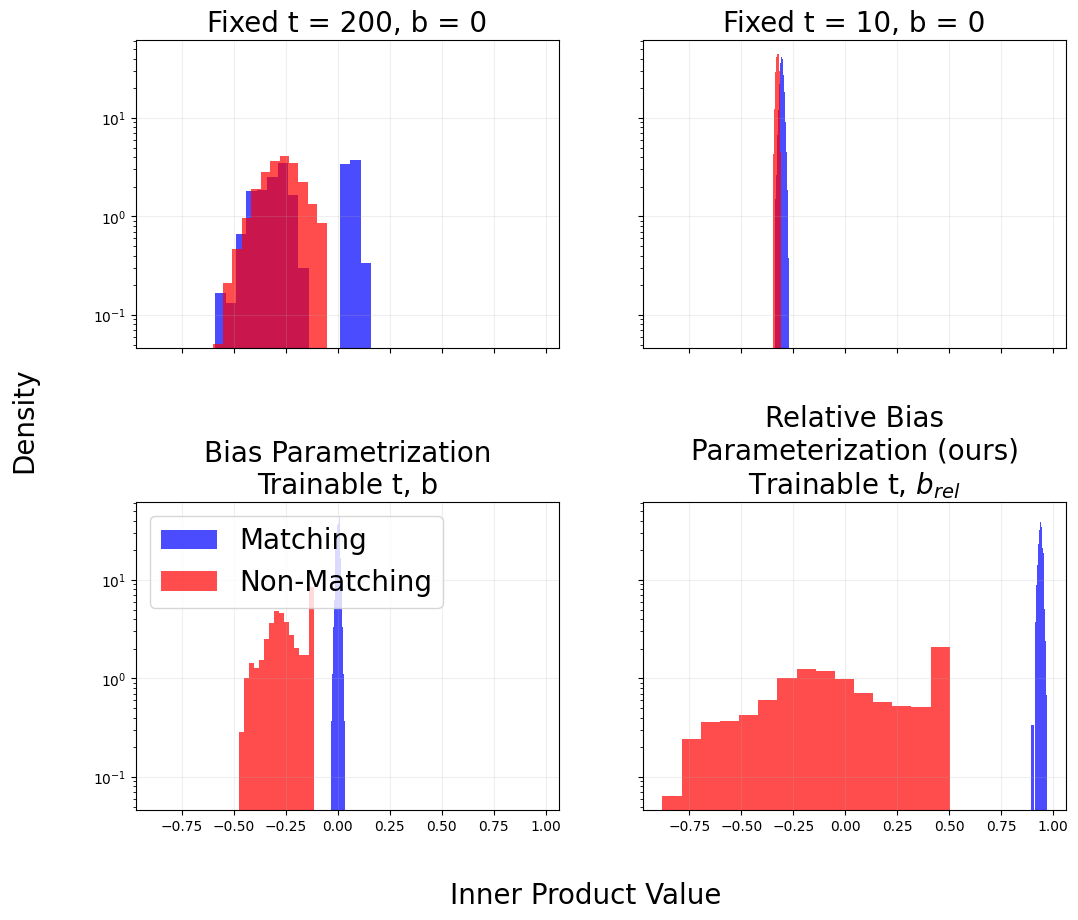

In [11]:
# --- Plotting all four in a 2×2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, gridspec_kw={'hspace': 0.5})

titles = [
        "Fixed t = 200, b = 0",
        "Fixed t = 10, b = 0",
        '\nBias Parametrization\nTrainable t, b',
        '\nRelative Bias\nParameterization (ours)\nTrainable t, $b_{rel}$',
        ]
for idx, cfg in enumerate(configs):
    ax = axes[idx // 2, idx % 2]
    vecs = results[cfg['name']]['vectors']
    # collect inner products
    match, nonmatch = [], []
    for i in range(len(vecs)):
        for j in range(i+1, len(vecs)):
            ip = vecs[i] @ vecs[j].t()
            match.extend(torch.diag(ip).numpy())
            mask = ~np.eye(ip.shape[0],dtype=bool)
            nonmatch.extend(ip.numpy()[mask])
    match = np.array(match)
    matching_jitter = match + np.random.normal(loc=0.0,
                                                        scale=0.01,
                                                        size=match.shape)
    # print(f'{cfg=}, {match=}')
    ax.hist(matching_jitter, bins=15, alpha=0.7, label='Matching', density=True, log=True, color = "blue")
    ax.hist(nonmatch, bins=15, alpha=0.7, label='Non-Matching', density=True, log=True,color = 'red')
    ax.set_title(titles[idx], fontsize = 20)
    if idx == 2:
        ax.legend(fontsize = 20, loc = 'upper left')
    ax.grid(alpha=0.2)


fig.supxlabel('Inner Product Value', fontsize=20)
fig.supylabel('Density',             fontsize=20)
plt.tight_layout()
plt.savefig("logs/multiplemodalities_ip_separation.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [12]:
# Experiment hyperparams
torch.manual_seed(50)
n_classes = 100
dim = 10
modalities_list = [4, 6, 8, 10]
n_epochs = int(1e4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

initial_temperature = 10.0
initial_relative_bias = 0.0
bias_is_trainable = True
lr = 1e-2

# Container for final vectors
all_results = {}

for n_modalities in modalities_list:
    print(f"→ Training with {n_modalities} modalities...")
    
    # Initialize modality vectors
    modality_vectors = []
    for _ in range(n_modalities):
        U_init, _ = generate_class_vectors(n_classes, dim, device)
        vecs = nn.Parameter(U_init / U_init.norm(dim=1, keepdim=True))
        modality_vectors.append(vecs)
    
    # SigLIP loss
    criterion = SigLIPLoss(
        temperature=initial_temperature,
        relative_bias=initial_relative_bias,
        trainable_bias=bias_is_trainable
    ).to(device)
    
    # Optimizer over both vectors and loss parameters
    optim_params = [{'params': mv, 'lr': lr} for mv in modality_vectors]
    optim_params.append({'params': criterion.parameters(), 'lr': lr})
    optimizer = torch.optim.Adam(optim_params)
    
    # Training loop
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        total_loss = 0
        for i in range(n_modalities):
            for j in range(i+1, n_modalities):
                total_loss += criterion(modality_vectors[i], modality_vectors[j])
        total_loss = total_loss / (n_modalities*(n_modalities-1)/2)
        total_loss.backward()
        optimizer.step()
        
        # Re-project onto unit sphere
        with torch.no_grad():
            for mv in modality_vectors:
                mv.data.div_(mv.data.norm(dim=1, keepdim=True))
    
    # Detach and store
    all_results[n_modalities] = [mv.detach().cpu() for mv in modality_vectors]
# Plotting


→ Training with 4 modalities...
→ Training with 6 modalities...
→ Training with 8 modalities...
→ Training with 10 modalities...


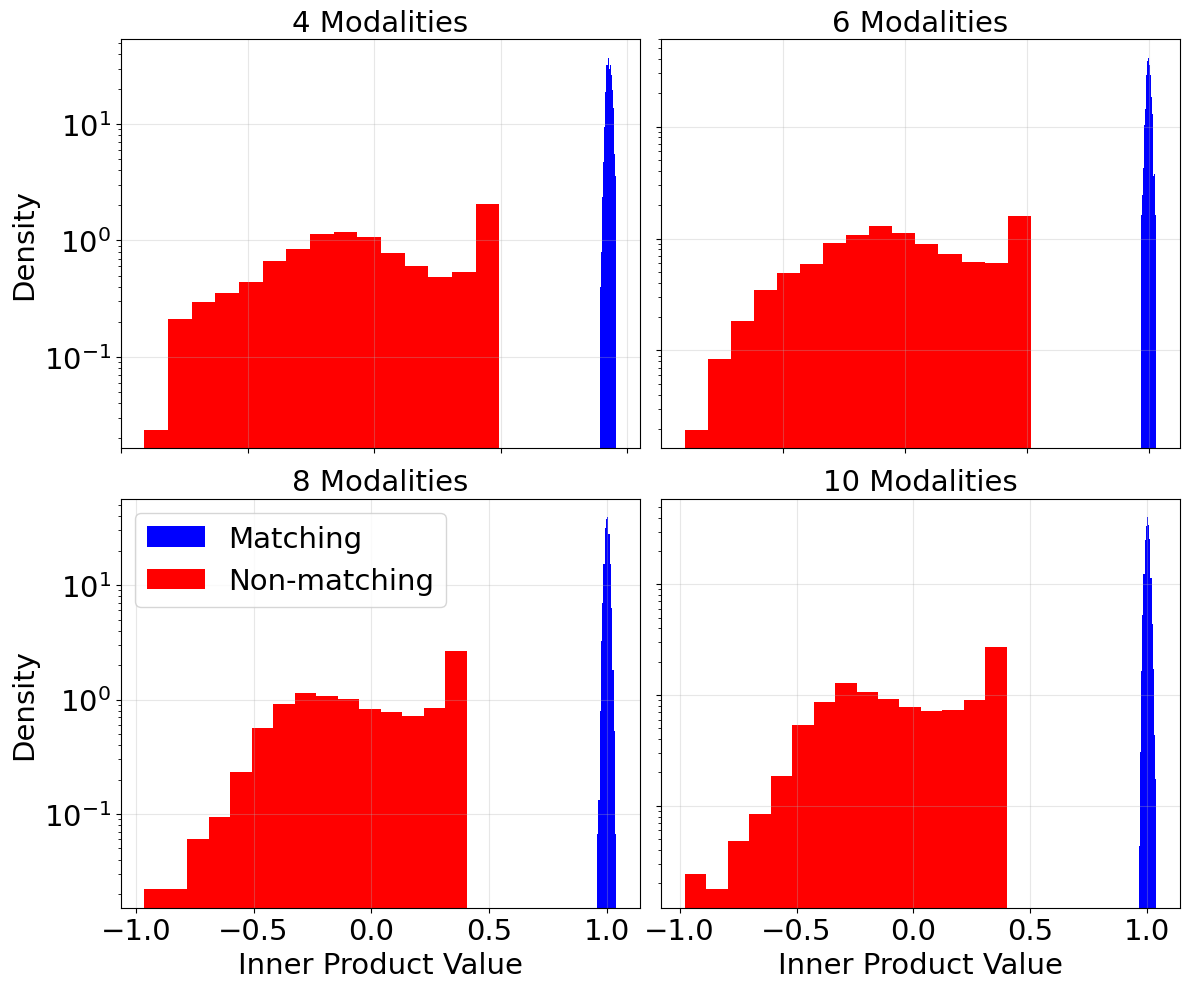

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (ax, n_mod) in enumerate(zip(axes, modalities_list)):
    final_vecs = all_results[n_mod]
    matching = []
    non_matching = []
    
    for i in range(n_mod):
        for j in range(i+1, n_mod):
            ip = final_vecs[i] @ final_vecs[j].T  # inner product matrix
            diag = ip.diag().numpy()
            # Add Gaussian noise to matching inner products
            matching.extend(diag + np.random.normal(0, 0.01, size=diag.shape))
            
            mask = ~np.eye(n_classes, dtype=bool)
            non_diag = ip.numpy()[mask]
            non_matching.extend(non_diag)
    
    ax.hist(matching, bins=15, label='Matching', color = 'blue', density=True, log=True)
    ax.hist(non_matching, bins=15, label='Non-matching', color = 'red', density=True, log=True)
    
    ax.set_title(f'{n_mod} Modalities', fontsize=21)
    
    # Only show x labels for bottom plots
    if idx >= 2:
        ax.set_xlabel('Inner Product Value', fontsize=21)
    else:
        ax.set_xlabel('')
        ax.tick_params(axis='x', which='both', labelbottom=False)
    
    # Only show y labels for left plots
    if idx % 2 == 0:
        ax.set_ylabel('Density', fontsize=21)
    else:
        ax.set_ylabel('')
        ax.tick_params(axis='y', which='both', labelleft=False)
    
    # Only show legend on bottom left plot
    if idx == 2:
        ax.legend(fontsize=21)
    else:
        ax.legend().remove()
    
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=21)

plt.tight_layout()
plt.savefig("logs/46810modalities_ip_separation.png", dpi = 300, bbox_inches = "tight")
plt.show()

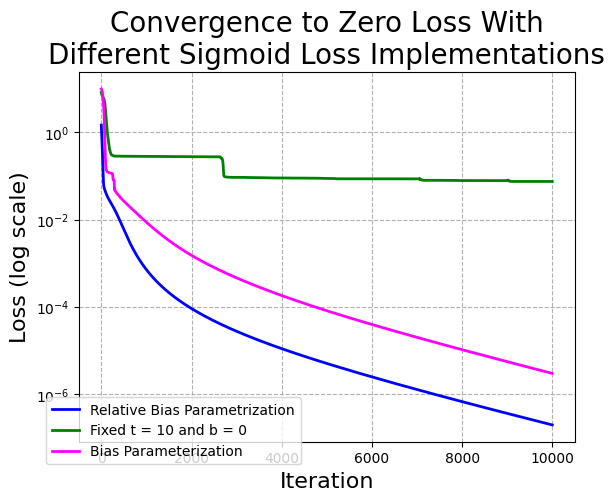

In [14]:
#plt.figure(figsize=(8, 6))
iters= np.arange(10000)
# Plot the two lines

plt.plot(iters, relative_bias_losses , label='Relative Bias Parametrization', linewidth=2,color = "blue")
plt.plot(iters, fixed_losses, label= 'Fixed t = 10 and b = 0', linewidth=2,color = "green")
plt.plot(iters, bias_losses, label= 'Bias Parameterization', linewidth=2,color = "magenta")
# plt.plot(iters, losses_t200[:10000], label= 't = 200 - fixed, b - trainable', linewidth=2,color = "red")

# Set log scale on y-axis (or use plt.xscale("log") for x-axis)
plt.yscale('log')

# Add labels and title
plt.xlabel('Iteration', fontsize = 16)
plt.ylabel('Loss (log scale)', fontsize = 16)
plt.title('Convergence to Zero Loss With\nDifferent Sigmoid Loss Implementations', fontsize = 20)
plt.legend(fontsize = 10,loc='lower left', bbox_to_anchor=(-.08, -.08))
plt.grid(True, which='both', linestyle='--')

plt.savefig('logs/losscomparisonadaptervsno.png',dpi =300,  bbox_inches='tight')
# Show the plot
plt.show()

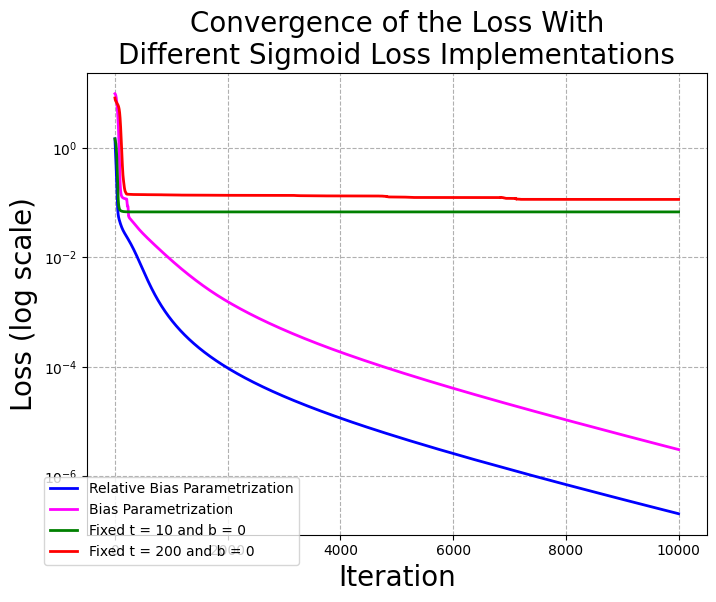

In [15]:
n_iters = len(next(iter(results.values()))['losses'])
iters = np.arange(n_iters)

# Extract the three (or four) loss arrays:
fixed_losses         = results['fixed_T10_b-10']['losses']
relative_bias_losses = results['trainable_T10_b-10_rel']['losses']
bias_losses          = results['trainable_T10_b-10_no_rel']['losses']
t200_losses          = results['fixed_T200_b-10']['losses']

plt.figure(figsize=(8, 6))

plt.plot(iters, relative_bias_losses, label='Relative Bias Parametrization', linewidth=2, color="blue")
plt.plot(iters, bias_losses,           label='Bias Parametrization',          linewidth=2, color="magenta")
plt.plot(iters, fixed_losses,          label='Fixed t = 10 and b = 0',      linewidth=2, color="green")
plt.plot(iters, t200_losses,        label='Fixed t = 200 and b = 0',    linewidth=2, color="red")

plt.yscale('log')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Loss (log scale)', fontsize=20)
plt.title(
    'Convergence of the Loss With\nDifferent Sigmoid Loss Implementations',
    fontsize=20
)
plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(-.08, -.08))
plt.grid(True, which='both', linestyle='--')

# make sure this folder exists, or change path as you like
plt.savefig('logs/multiplemodalities_loss_comparison.png', dpi=300, bbox_inches='tight')
plt.show()